In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import utils
import alignment

INFO: Using numpy backend


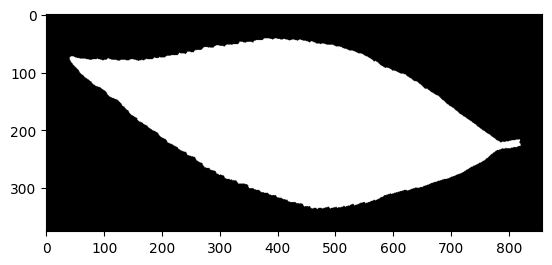

In [2]:
data_path = os.path.join(os.getcwd(), 'data/leaf_dataset/images/')
data_raw = []
for file in os.listdir(data_path):
    if file.endswith('.jpg'):
        data_raw.append(plt.imread(data_path + file))

plt.imshow(data_raw[0], cmap = 'gray')

In [ ]:
data = []
for shape in data_raw:
    line = plt.contour(shape, levels=[1]).collections[0].get_paths()[0].vertices
    data.append(line)

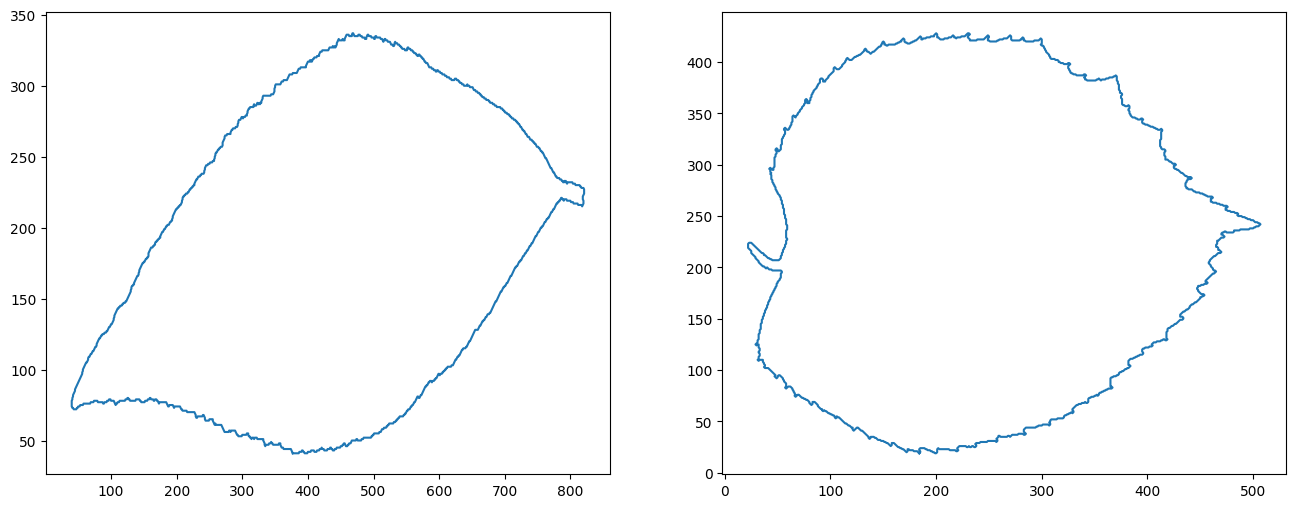

In [4]:
fig, ax = plt.subplots(1,2 , figsize = (16,6))
ax[0].plot(data[0][:,0] , data[0][:,1])
ax[1].plot(data[1][:,0] , data[1][:,1])

### Interpolation

Before we align the shapes and create a shape model, we need to check if all shapes have the same amount of data points.

In [5]:
lengths = []
for curve in data:
    lengths.append(curve.shape[0])
# Run over all shapes and print True if all curves have the same length, otherwise False
base = lengths[0]
check = True
for item in lengths:
    if item != base:
        check = False
        break
print(check)



False


As our shapes are of different lengths, we first use the interpolate function, which transforms every shape to a chosen number of sampling points. The function also makes sure there are no duplicate points in the shape after the interpolation.

In [6]:
nb_points = 500
data_interp = utils.apply_func_to_list(
    input_list=data, func=lambda x: utils.interpolate(x, nb_points)
)


### Alignment

#### Procrustes alignment

The first alignment method we use is the Procrustes analysis alignment. The standard procrustes analysis uses a shape as a reference shape (usually the first shape in the dataset).<br>
It takes every shape in the dataset and first performs standardization (mean 0 and standard deviation 1) and centering around the origin. Then, the shape is transformed (scaled and rotated) to best fit the reference shape, meaning to minimize the sum of squares of the pointwise differences.

In [7]:
data_procustes = utils.apply_func_to_list(
    input_list=data_interp, func=lambda x: alignment.procrustes(shape = x, ref_shape= data_interp[0])
)


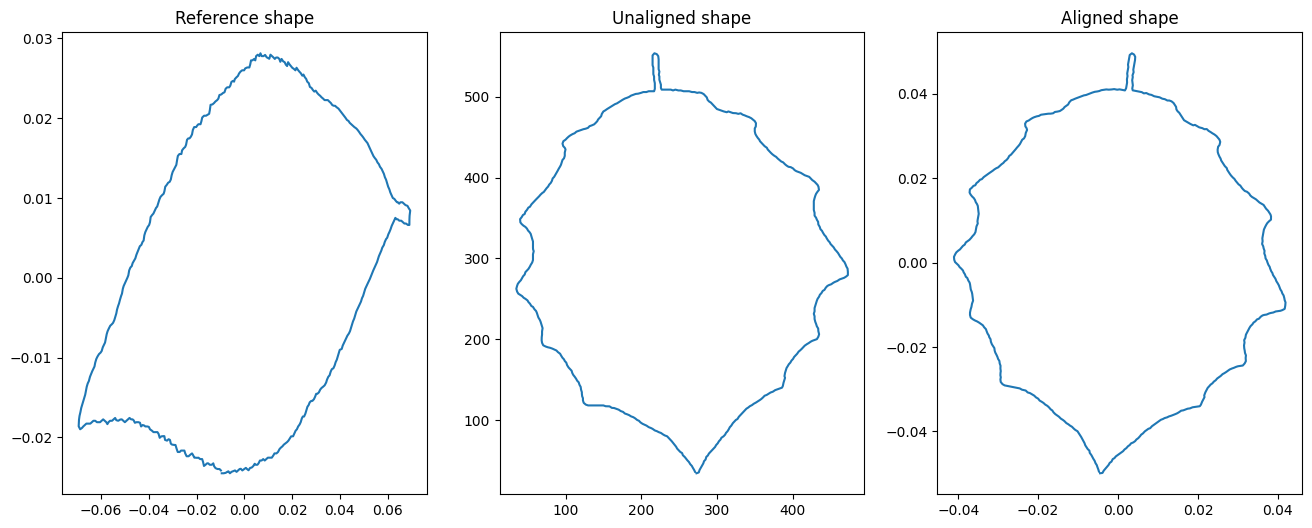

In [19]:
fig, ax = plt.subplots(1,3 , figsize = (16,6))
ax[0].plot(data_procustes[0][:,0] , data_procustes[0][:,1])
ax[1].plot(data_interp[4][:,0] , data_interp[4][:,1])
ax[2].plot(data_procustes[4][:,0] , data_procustes[4][:,1])

ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')

plt.show()

As we can see, the alignment is far from being satisfactory. This is probably due to the fact that our shapes don't have correspondence. In order to deal with this problem, we  perform a correspondence search. The idea is to find the point correspondence that minimizes the pointwise distance out of all alignment attemps. We iteratively pick a point as a starting point, align the shape to the reference shape and move on to try the next point as the starting point. The point that produces the best alignment (smallest pointwise distance) is our best correspondence point.